### DTSA 5511 Cancer Detection Kaggle Mini-Project

**Step 1**

**Brief Description of the problem and data(5 pts)**

Metastatic Cancer (source : https://www.cancer.gov/types/metastatic-cancer#what)

The process by which cancer cells spread to other parts of the body is called metastatsis. It is also called Stage IV Cancer.
When observed under a microscope and tested in other ways, metastatic cancer cells have features like that of the primary cancer and not like the cells in the place where the metastatic cancer is found. This is how doctors can tell that it is cancer that has spread from another part of the body.

The goal is to create a model to identify metastatic cancer in images taken from larger digital pathology scanes. The images are taken from modified version of PatchCamelyon(PCam) benchmark dataset. 

We are provided with small pathology images. The files are named with an image id. Positive lables indicates that the center 32x32px region of a patch contains atleast one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.


In [56]:
# import necessary libraries
import numpy as np
import pandas as pd
import os

# Visuzalisation
import matplotlib.pyplot as plt
import seaborn as sns


**Step 2**

**Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)**

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 


In [57]:

test_path = '/Users/kgb/Documents/histopathologic-cancer-detection/test/'
train_path = '/Users/kgb/Documents/histopathologic-cancer-detection/train/'
train_data = pd.read_csv('/Users/kgb/Documents/histopathologic-cancer-detection/train_labels.csv')


In [58]:
# Check the null values, shape , any other info from train_data
train_data.info()
train_data.isnull().sum()
train_data.shape
train_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


**id corresponds to the file name of image in training path. There are two categories in label. 0 means Non-cancerous and 1 is cancerous.**

In [59]:
# Check the distribution of data in train_data
train_data['label'].value_counts()

# percentage of positive and negative data
train_data['label'].value_counts()/len(train_data)


0    0.594969
1    0.405031
Name: label, dtype: float64

**Around 40% of the train data is Cancerous**

In [60]:
print("No of Images in Training Set: {}".format(len(os.listdir(train_path))))
print("No of Images in Test Set: {}".format(len(os.listdir(test_path))))

No of Images in Training Set: 220025
No of Images in Test Set: 57458


**Sample random 10 images along with lables (mapping from training data) are displayed below**

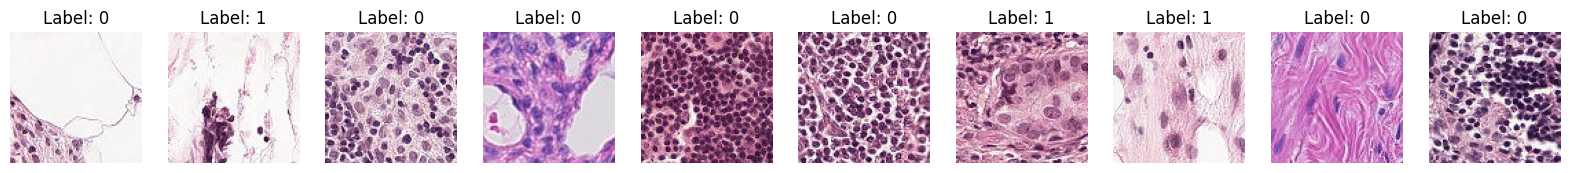

In [61]:
from matplotlib.image import imread
fig, ax = plt.subplots(1, 10, figsize=(20, 10))
for i in range(10):
    ax[i].imshow(imread(train_path + train_data['id'][i] + '.tif'))
    ax[i].axis('off')
    ax[i].set_title('Label: ' + str(train_data['label'][i]))
plt.show()


**Step 3**

**DModel Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.

In [62]:
# Importing Keras Libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import pydot
import graphviz
import visualkeras



In [64]:
# Cretea a CNN Model using three layers - A convolutional layer, a pooling layer and a dense layer
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(96,96,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer
model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(96,96,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=(96,96,3), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layer
model.add(Flatten())

# Dense Layer
model.add(Dense(256))
model.add(Activation('relu'))

# Dropout Layer

model.add(Dropout(0.5))

# Dense Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.0001),
                metrics=['accuracy'])

model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 47, 47, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 10, 10, 128)     

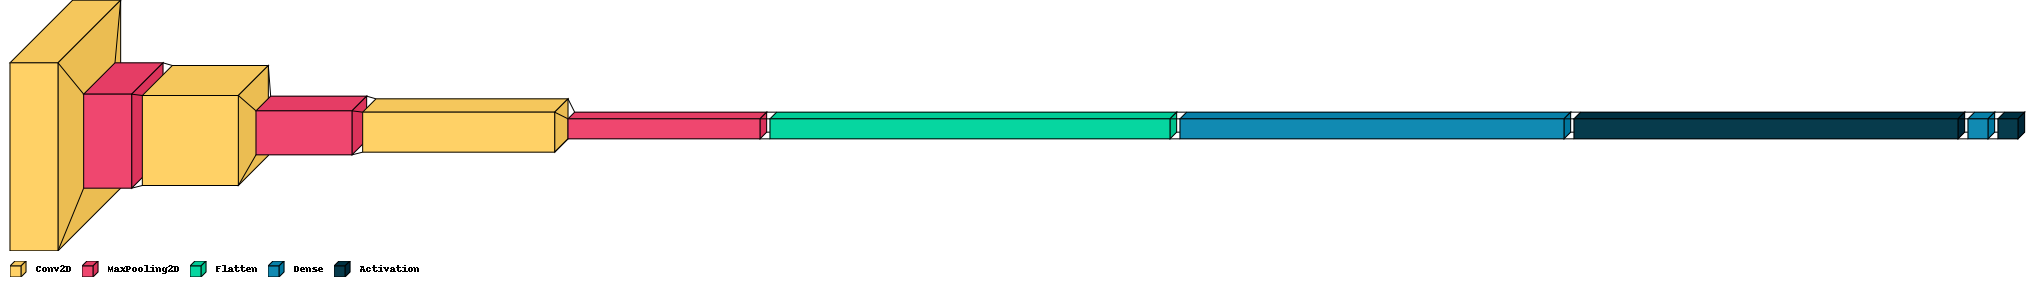

In [65]:
visualkeras.layered_view(model, type_ignore=[Dropout, BatchNormalization], legend=True, scale_xy=2, scale_z=1.5)

In [74]:
# Define the data generators
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set the batch size
batch_size = 32

# Set the image size
image_size = (96, 96)

# Split the data
from sklearn.model_selection import train_test_split
train_data, validation_data = train_test_split(train_data, test_size=0.1, random_state=101)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train_data,
                                                    directory=train_path,
                                                    x_col='id',
                                                    y_col='label',
                                                    target_size=image_size,
                                                    class_mode='binary',
                                                    batch_size=batch_size)

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_dataframe(validation_data,
                                                        directory=train_path,
                                                        x_col='id',
                                                        y_col='label',
                                                        target_size=image_size,
                                                        class_mode='binary',
                                                        batch_size=batch_size)





TypeError: If class_mode="binary", y_col="label" column values must be strings.

**Step 4**

**Results and Analysis (35 pts)** 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

**Step 5**

**Conclusion (15 pts)**

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

**Step 6**

**Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard (35 points)**

